### Mise en place

Cette partie vise à récupérer n données sur les capteurs, créer un modèle en faisant un entrainement sur les n-1 données et enfin tester le modèle sur 1 sujet. 

In [21]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### Récupération des données

In [22]:
import zipfile
import urllib

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/"
WISDM_PATH = os.path.join("datasets", "wisdm")
WISDM_URL = DOWNLOAD_ROOT + "wisdm-dataset.zip"

def fetch_wisdm_data(wisdm_url=WISDM_URL, wisdm_path=WISDM_PATH):
    if not os.path.isdir(wisdm_path):
        os.makedirs(wisdm_path)
    zip_path = os.path.join(wisdm_path, "wisdm-dataset.zip")
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(wisdm_url, zip_path)
    uncompressed_path = os.path.join(wisdm_path, "wisdm-dataset")
    if not os.path.isdir(uncompressed_path):
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(wisdm_path)

## Etude des données venant de l'accéléromètre des smartwaches
### Téléchargement des données provenant des smartwatches 

In [30]:
import random
from random import randint

import arff
import pandas as pd

#Récupération des données d'une seule instance
def load_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    subjectIdStr = str(subjectId)
    arffPath = os.path.join(WISDM_PATH,'wisdm-dataset','arff_files',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.arff')
    return arff.load(open(arffPath, 'r'))

# Création d'un dataframe à partir des données d'un sujet
wisdmExample = load_wisdm_data(1600, 'watch', 'accel')
attributesName = [wisdmExample['attributes'][i][0] for i in range (len(wisdmExample['attributes']))]
data = pd.DataFrame(data = wisdmExample['data'], columns = attributesName) 


In [24]:
# Récupération des données de plusieurs instances
SUBJECT_NUMBER = 51
FIRST_SUBJECT_ID=1600
l = [i+FIRST_SUBJECT_ID for i in range(SUBJECT_NUMBER)]
SUBJECTSID= l.remove(1614) #Le sujet 1614 n'est pas dans la liste ...

def load_multiple_wisdm_data(subjectToExtractNumber, device, sensor, method):
    d = []
    random.seed(1) #for reproductibility
    subjectToExtract = random.sample(l,subjectToExtractNumber)
    
    # Un seul dataframe pour tous les sujets
    if(method==1): 
        subjectsDf = pd.DataFrame(data = wisdmExample['data'], columns = attributesName)
        for i in range(subjectToExtractNumber):
            dataArff = load_wisdm_data(subjectToExtract[i], device, sensor)
            subjectDf = pd.DataFrame(data = dataArff['data'], columns = attributesName) 
            subjectsDf = subjectsDf.append(subjectDf)
        return subjectsDf 
    
    # Possibilité de créer une collection de dataFrames
    if(method==2):
        for i in range(subjectToExtractNumber):
            d.append(load_wisdm_data(subjectToExtract[i], device, sensor))
        return d      

#### Creation d'une collection de 10 dataframes correspondant aux données de 10 personnes

In [31]:
#Methode 1 
collection1 = load_multiple_wisdm_data(10, 'watch', 'accel', 1)

#Methode2
def create_dataFrame_fromArff(collection):
    dataFrameCollection = {}
    for i in range(len(collection)):
        dataOnePerson = collection[i]
        dataFrameCollection[i] = pd.DataFrame(data = dataOnePerson['data'], columns = attributesName) 
    return dataFrameCollection

collection2 = load_multiple_wisdm_data(10, 'watch', 'accel',2)
dataFrame = create_dataFrame_fromArff(collection2)

### Vérification de la qualité des données

In [96]:
# Vérification de doublons
dups = collection1.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [99]:
import numpy as np

# Vérification de valeurs manquantes
collection1 = collection1.replace('?',np.NaN)
print('Number of instances = %d' % (collection1.shape[0]))
print('Number of attributes = %d' % (collection1.shape[1]))

print('Number of missing values:')
for col in collection1.columns:
    print('\t%s: %d' % (col,collection1[col].isna().sum()))

Number of instances = 4019
Number of attributes = 93
Number of missing values:
	ACTIVITY: 0
	X0: 0
	X1: 0
	X2: 0
	X3: 0
	X4: 0
	X5: 0
	X6: 0
	X7: 0
	X8: 0
	X9: 0
	Y0: 0
	Y1: 0
	Y2: 0
	Y3: 0
	Y4: 0
	Y5: 0
	Y6: 0
	Y7: 0
	Y8: 0
	Y9: 0
	Z0: 0
	Z1: 0
	Z2: 0
	Z3: 0
	Z4: 0
	Z5: 0
	Z6: 0
	Z7: 0
	Z8: 0
	Z9: 0
	XAVG: 0
	YAVG: 0
	ZAVG: 0
	XPEAK: 0
	YPEAK: 0
	ZPEAK: 0
	XABSOLDEV: 0
	YABSOLDEV: 0
	ZABSOLDEV: 0
	XSTANDDEV: 0
	YSTANDDEV: 0
	ZSTANDDEV: 0
	XVAR: 0
	YVAR: 0
	ZVAR: 0
	XMFCC0: 0
	XMFCC1: 0
	XMFCC2: 0
	XMFCC3: 0
	XMFCC4: 0
	XMFCC5: 0
	XMFCC6: 0
	XMFCC7: 0
	XMFCC8: 0
	XMFCC9: 0
	XMFCC10: 0
	XMFCC11: 0
	XMFCC12: 0
	YMFCC0: 0
	YMFCC1: 0
	YMFCC2: 0
	YMFCC3: 0
	YMFCC4: 0
	YMFCC5: 0
	YMFCC6: 0
	YMFCC7: 0
	YMFCC8: 0
	YMFCC9: 0
	YMFCC10: 0
	YMFCC11: 0
	YMFCC12: 0
	ZMFCC0: 0
	ZMFCC1: 0
	ZMFCC2: 0
	ZMFCC3: 0
	ZMFCC4: 0
	ZMFCC5: 0
	ZMFCC6: 0
	ZMFCC7: 0
	ZMFCC8: 0
	ZMFCC9: 0
	ZMFCC10: 0
	ZMFCC11: 0
	ZMFCC12: 0
	XYCOS: 0
	XZCOS: 0
	YZCOS: 0
	XYCOR: 0
	XZCOR: 0
	YZCOR: 0
	RESULTANT: 0
	class: 0


Il n'y a pas de valeurs manquantes dans les données ni de doublons

#### Pour connaitre le type de chaque attribut  

In [32]:
collection1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4019 entries, 0 to 332
Data columns (total 93 columns):
ACTIVITY     4019 non-null object
X0           4019 non-null float64
X1           4019 non-null float64
X2           4019 non-null float64
X3           4019 non-null float64
X4           4019 non-null float64
X5           4019 non-null float64
X6           4019 non-null float64
X7           4019 non-null float64
X8           4019 non-null float64
X9           4019 non-null float64
Y0           4019 non-null float64
Y1           4019 non-null float64
Y2           4019 non-null float64
Y3           4019 non-null float64
Y4           4019 non-null float64
Y5           4019 non-null float64
Y6           4019 non-null float64
Y7           4019 non-null float64
Y8           4019 non-null float64
Y9           4019 non-null float64
Z0           4019 non-null float64
Z1           4019 non-null float64
Z2           4019 non-null float64
Z3           4019 non-null float64
Z4           4019 no

In [27]:
collection1.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.0,0.0,0.0,0.045,0.090,0.190,0.215,0.210,0.135,...,0.504662,0.498178,-0.395887,-0.105039,-0.263814,-0.035912,-0.305539,-0.292265,12.7783,1600
1,A,0.0,0.0,0.0,0.000,0.030,0.250,0.305,0.225,0.125,...,0.497101,0.490714,-0.517585,-0.493655,0.208926,-0.166636,0.071774,-0.070860,12.8712,1600
2,A,0.0,0.0,0.0,0.000,0.015,0.280,0.300,0.210,0.140,...,0.438027,0.432398,-0.573148,-0.468498,0.001704,-0.090878,0.005053,-0.382557,12.5949,1600
3,A,0.0,0.0,0.0,0.005,0.070,0.245,0.275,0.220,0.130,...,0.447493,0.441743,-0.514097,-0.232246,-0.080241,-0.117089,0.137656,-0.265747,12.3521,1600
4,A,0.0,0.0,0.0,0.000,0.015,0.260,0.325,0.230,0.110,...,0.433304,0.427736,-0.461254,0.084470,-0.418888,-0.097265,-0.118795,-0.414198,12.4168,1600


#### Affichage des détails statistiques pour les sujets 

In [28]:
collection1.describe(include='all')

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
count,4019,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,...,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019
unique,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
top,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1637
freq,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,759
mean,NaN,0.326454,0.175039,0.109118,0.056755,0.057646,0.167973,0.057589,0.021089,0.010506,...,0.447729,0.441976,-0.002220,-0.161696,-0.203593,-0.147485,0.071639,0.141935,10.879248,NaN
std,NaN,0.376688,0.268446,0.218989,0.138122,0.114749,0.298017,0.134597,0.046304,0.024297,...,0.177584,0.175302,0.717855,0.640440,0.630581,0.417432,0.457104,0.418696,2.412418,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.304238,-0.300329,-0.999970,-0.999991,-0.999954,-0.997431,-0.995464,-0.995789,9.163820,NaN
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.351059,0.346549,-0.673922,-0.757699,-0.780061,-0.426554,-0.266363,-0.131447,9.795145,NaN
50%,NaN,0.150000,0.055000,0.015000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,...,0.443612,0.437912,-0.082495,-0.238158,-0.293608,-0.164653,0.083062,0.159042,9.989970,NaN
75%,NaN,0.630000,0.215000,0.105000,0.065000,0.085000,0.190000,0.055000,0.015000,0.005000,...,0.566929,0.559645,0.763147,0.355231,0.257731,0.112264,0.422905,0.446372,10.865450,NaN


In [59]:
pd.set_option('display.max_rows', 50)
print('Covariance')
collection1.cov()

Covariance


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,0.141894,-0.018062,-0.023366,-0.011484,-0.012957,-0.049975,-0.015886,-0.005020,-0.002193,-0.002950,...,0.007944,0.007851,0.007750,0.181492,-0.053857,-0.033129,-0.036391,0.035031,0.007734,-0.046928
X1,-0.018062,0.072063,-0.000047,-0.005740,-0.007062,-0.026369,-0.008695,-0.002946,-0.001372,-0.001770,...,-0.000148,-0.000146,-0.000144,0.079707,-0.033600,-0.033483,-0.006684,0.001553,0.006794,-0.103707
X2,-0.023366,-0.000047,0.047956,0.000048,-0.002689,-0.014762,-0.004628,-0.001409,-0.000608,-0.000495,...,0.002670,0.002639,0.002605,-0.039161,0.047252,-0.029551,0.009099,0.002708,0.005092,-0.029179
X3,-0.011484,-0.005740,0.000048,0.019078,0.003516,-0.005177,-0.000930,0.000078,0.000109,0.000504,...,0.004501,0.004449,0.004392,-0.030956,0.013994,0.004850,0.003788,-0.002964,0.000168,0.027643
X4,-0.012957,-0.007062,-0.002689,0.003516,0.013167,0.001286,0.001852,0.001359,0.000649,0.000879,...,0.003686,0.003643,0.003596,-0.032914,0.005249,0.015605,0.004978,-0.007278,-0.003027,0.033236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.033129,-0.033483,-0.029551,0.004850,0.015605,0.042879,0.019646,0.006209,0.002999,0.003976,...,0.011297,0.011165,0.011022,-0.114630,-0.032045,0.397633,0.000725,-0.039822,-0.014876,0.304728
XYCOR,-0.036391,-0.006684,0.009099,0.003788,0.004978,0.029283,-0.003037,-0.000416,-0.000064,-0.000556,...,-0.000487,-0.000482,-0.000476,-0.069543,0.009378,0.000725,0.174249,0.043180,0.014639,-0.017079
XZCOR,0.035031,0.001553,0.002708,-0.002964,-0.007278,-0.010096,-0.007533,-0.005449,-0.002680,-0.003291,...,-0.005104,-0.005045,-0.004980,0.047235,-0.029382,-0.039822,0.043180,0.208944,-0.023584,-0.224608
YZCOR,0.007734,0.006794,0.005092,0.000168,-0.003027,-0.005199,-0.004776,-0.002396,-0.001260,-0.003129,...,-0.008907,-0.008803,-0.008690,0.044696,-0.065916,-0.014876,0.014639,-0.023584,0.175307,-0.114681


In [60]:
correlationMatrix = collection1.corr()
print('Correlation :')
collection1.corr()

Correlation :


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,1.000000,-0.178623,-0.283260,-0.220721,-0.299751,-0.445177,-0.313333,-0.287796,-0.239571,-0.171591,...,0.117368,0.117368,0.117368,0.671179,-0.223246,-0.139472,-0.231433,0.203447,0.049039,-0.051641
X1,-0.178623,1.000000,-0.000793,-0.154816,-0.229255,-0.329604,-0.240650,-0.236983,-0.210356,-0.144461,...,-0.003063,-0.003063,-0.003063,0.413619,-0.195438,-0.197802,-0.059651,0.012657,0.060447,-0.160139
X2,-0.283260,-0.000793,1.000000,0.001576,-0.107022,-0.226197,-0.156996,-0.138997,-0.114185,-0.049514,...,0.067848,0.067848,0.067848,-0.249112,0.336916,-0.214000,0.099533,0.027054,0.055531,-0.055233
X3,-0.220721,-0.154816,0.001576,1.000000,0.221830,-0.125781,-0.050016,0.012155,0.032352,0.079944,...,0.181383,0.181383,0.181383,-0.312206,0.158196,0.055688,0.065708,-0.046941,0.002908,0.082960
X4,-0.299751,-0.229255,-0.107022,0.221830,1.000000,0.037594,0.119889,0.255828,0.232730,0.167857,...,0.178788,0.178787,0.178787,-0.399576,0.071421,0.215667,0.103930,-0.138762,-0.063009,0.120063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.139472,-0.197802,-0.214000,0.055688,0.215667,0.228173,0.231466,0.212644,0.195721,0.138119,...,0.099706,0.099706,0.099706,-0.253234,-0.079349,1.000000,0.002752,-0.138154,-0.056345,0.200318
XYCOR,-0.231433,-0.059651,0.099533,0.065708,0.103930,0.235389,-0.054053,-0.021533,-0.006283,-0.029180,...,-0.006500,-0.006500,-0.006500,-0.232077,0.035078,0.002752,1.000000,0.226299,0.083758,-0.016960
XZCOR,0.203447,0.012657,0.027054,-0.046941,-0.138762,-0.074110,-0.122444,-0.257438,-0.241343,-0.157743,...,-0.062146,-0.062146,-0.062146,0.143949,-0.100367,-0.138154,0.226299,1.000000,-0.123226,-0.203685
YZCOR,0.049039,0.060447,0.055531,0.002908,-0.063009,-0.041664,-0.084751,-0.123610,-0.123899,-0.163725,...,-0.118398,-0.118398,-0.118398,0.148708,-0.245819,-0.056345,0.083758,-0.123226,1.000000,-0.113537


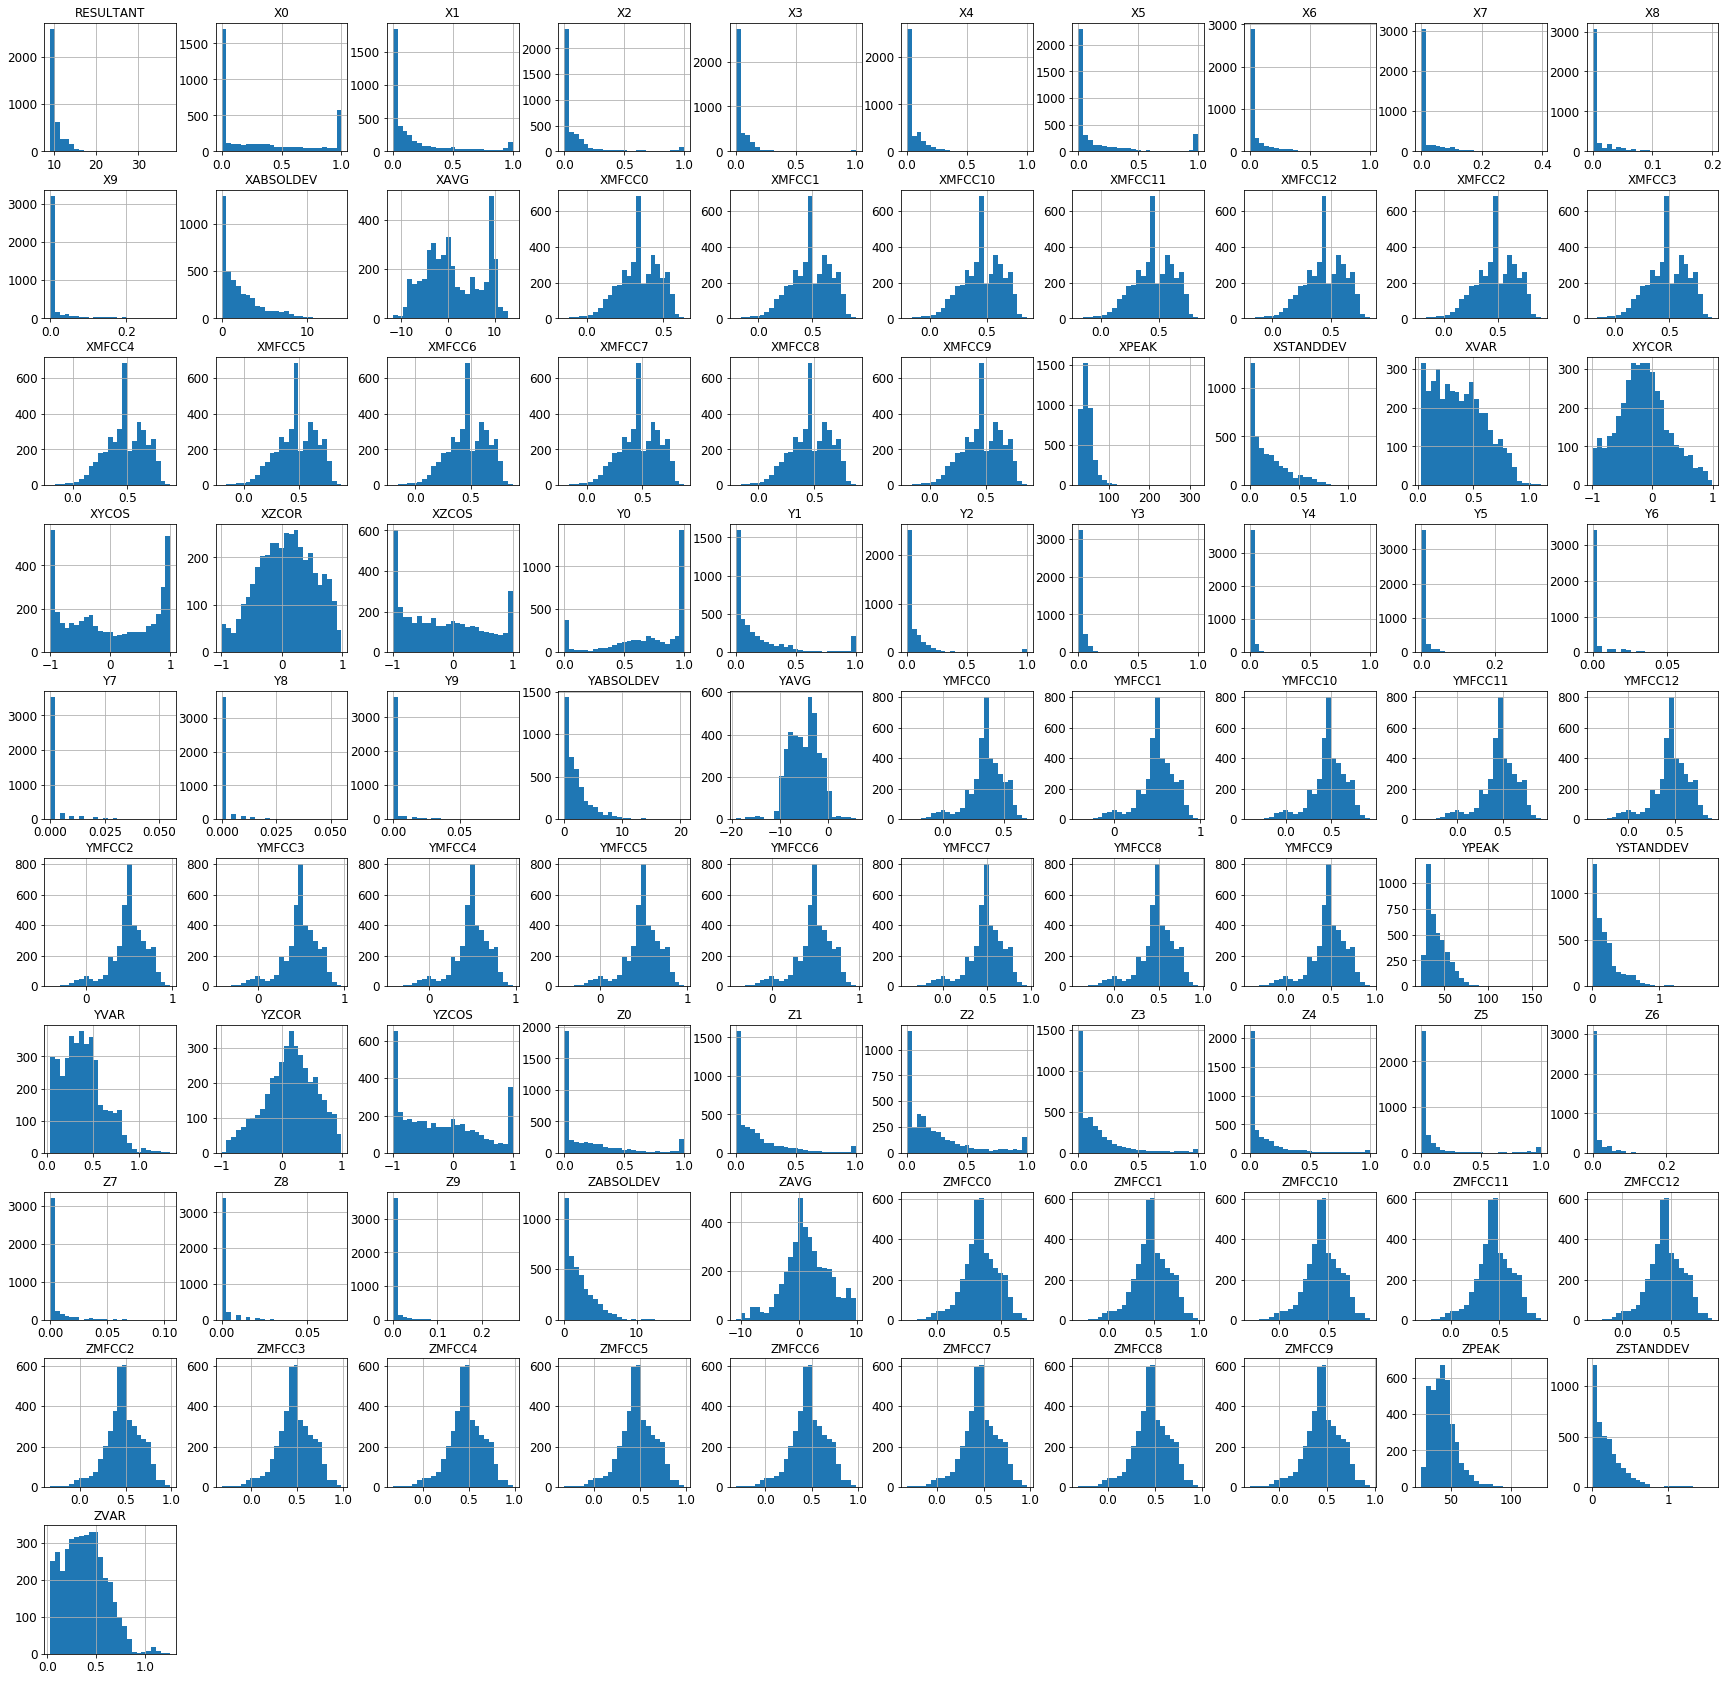

In [61]:
collection1.hist(bins = 25, figsize=(30,30))
plt.show()

On remarque que les histogrammes de certains attributs semblent similaires, comme ceux des attributs XMFCC{0-12}, les attributs YMFCC{0-12} et enfin ZMFCC{0-12}. Nous vérifierons par la suite la valeur de la corrélation entre ces attributs.

In [48]:
thresholdcorrelation = 0.80
correlationXMFCC = correlationMatrix["XMFCC0"].sort_values(ascending=False)**2
correlationXMFCC[correlationXMFCC>=thresholdcorrelation]

XMFCC0     1.0
XMFCC3     1.0
XMFCC1     1.0
XMFCC4     1.0
XMFCC6     1.0
XMFCC9     1.0
XMFCC8     1.0
XMFCC2     1.0
XMFCC5     1.0
XMFCC11    1.0
XMFCC12    1.0
XMFCC7     1.0
XMFCC10    1.0
Name: XMFCC0, dtype: float64

In [49]:
correlationYMFCC = correlationMatrix["YMFCC0"].sort_values(ascending=False)**2
correlationYMFCC[correlationYMFCC>=thresholdcorrelation]

YMFCC0     1.0
YMFCC3     1.0
YMFCC8     1.0
YMFCC2     1.0
YMFCC1     1.0
YMFCC7     1.0
YMFCC4     1.0
YMFCC6     1.0
YMFCC5     1.0
YMFCC9     1.0
YMFCC10    1.0
YMFCC12    1.0
YMFCC11    1.0
Name: YMFCC0, dtype: float64

In [50]:
correlationZMFCC = correlationMatrix["ZMFCC0"].sort_values(ascending=False)**2
correlationZMFCC[correlationZMFCC>=thresholdcorrelation]

ZMFCC0     1.0
ZMFCC2     1.0
ZMFCC4     1.0
ZMFCC1     1.0
ZMFCC3     1.0
ZMFCC7     1.0
ZMFCC6     1.0
ZMFCC5     1.0
ZMFCC11    1.0
ZMFCC9     1.0
ZMFCC10    1.0
ZMFCC8     1.0
ZMFCC12    1.0
Name: ZMFCC0, dtype: float64

Remarques : La corrélation entre les attributs XMFCC{0-12} est égale à 1. De même pour YMFCC{0-12} et ZMFCC{0-12}. On va donc ne prendre que un de chaque attribut par la suite

In [51]:
correlationX = correlationMatrix["XABSOLDEV"].sort_values(ascending=False)**2
correlationX[correlationX>=thresholdcorrelation]

XABSOLDEV    1.000000
XSTANDDEV    0.985238
XVAR         0.895710
Name: XABSOLDEV, dtype: float64

In [52]:
correlationY = correlationMatrix["YABSOLDEV"].sort_values(ascending=False)**2
correlationY[correlationY>=thresholdcorrelation]

YABSOLDEV    1.000000
YSTANDDEV    0.987259
YVAR         0.873629
Name: YABSOLDEV, dtype: float64

In [53]:
correlationZ = correlationMatrix["ZABSOLDEV"].sort_values(ascending=False)**2
correlationZ[correlationZ>=thresholdcorrelation]

ZABSOLDEV    1.000000
ZSTANDDEV    0.980034
ZVAR         0.901239
Name: ZABSOLDEV, dtype: float64

In [73]:
correlationXVAR = correlationMatrix["XVAR"].sort_values(ascending=False)**2
correlationXVAR[correlationXVAR>=thresholdcorrelation]

XVAR         1.000000
XSTANDDEV    0.927342
XABSOLDEV    0.895710
YVAR         0.828296
Name: XVAR, dtype: float64

Les attributs 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV' présentent une forte corrélation avec respectivement 'XSTANDDEV', 'YSTANDDEV' et 'ZSTANDDEV'. De plus ils ont aussi une forte corrélation avec respectivement 'XVAR', YVAR' et 'ZVAR'.

NB : Les attributs 'XVAR' et 'YVAR' sont très corrélés entre eux

On peut donc ne conserver que XVAR et ZVAR par exemple

In [74]:
correlationX = correlationMatrix["X0"].sort_values(ascending=False)**2
correlationX[correlationX>=thresholdcorrelation]

X0    1.0
Name: X0, dtype: float64

### Réduction du nombre d'attributs

In [80]:
# Liste initiale des attributs 
collection1.columns

Index(['ACTIVITY', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'XMFCC0',
       'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4', 'XMFCC5', 'XMFCC6', 'XMFCC7',
       'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12', 'YMFCC0', 'YMFCC1',
       'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5', 'YMFCC6', 'YMFCC7', 'YMFCC8',
       'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12', 'ZMFCC0', 'ZMFCC1', 'ZMFCC2',
       'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6', 'ZMFCC7', 'ZMFCC8', 'ZMFCC9',
       'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS', 'XZCOS', 'YZCOS', 'XYCOR',
       'XZCOR', 'YZCOR', 'RESULTANT', 'class'],
      dtype='object')

In [75]:
# Liste d'attributs qui seront pris en compte après qu'on ait enlevé les attributs ayant des histogrammes
# avec peu de dispersion ainsi que les attributs fortement correlés avec d'autres attributs
relevantAttributs = ['ACTIVITY', 'XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 
    'XVAR','ZVAR', 'XMFCC0', 'YMFCC0', 'ZMFCC0', 'XYCOS', 'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR',
    'YZCOR', 'RESULTANT', 'class']

def dataReduction(collection):
    return collection[relevantAttributs].copy()

reducedCollection = dataReduction(collection1)

In [76]:
reducedCollection.head()

,ACTIVITY,XAVG,YAVG,ZAVG,XPEAK,YPEAK,ZPEAK,XVAR,ZVAR,XMFCC0,YMFCC0,ZMFCC0,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,12.0689,-1.13570,-0.022859,52.7027,46.3415,44.8837,0.536482,0.454925,0.448836,0.393334,0.381289,-0.395887,-0.105039,-0.263814,-0.035912,-0.305539,-0.292265,12.7783,1600
1,A,12.1521,-1.75208,-1.327610,39.3750,40.0000,39.1837,0.469775,0.389927,0.460722,0.424565,0.375576,-0.517585,-0.493655,0.208926,-0.166636,0.071774,-0.070860,12.8712,1600
2,A,12.1529,-1.53875,-0.972243,43.4091,37.8846,39.7917,0.458741,0.352830,0.447815,0.371445,0.330943,-0.573148,-0.468498,0.001704,-0.090878,0.005053,-0.382557,12.5949,1600
3,A,11.9523,-1.31171,-0.505159,45.9524,45.0000,38.9796,0.481847,0.351878,0.445134,0.376999,0.338095,-0.514097,-0.232246,-0.080241,-0.117089,0.137656,-0.265747,12.3521,1600
4,A,12.0245,-1.03888,0.240671,40.6522,40.8511,45.0000,0.450940,0.383281,0.432201,0.357504,0.327375,-0.461254,0.084470,-0.418888,-0.097265,-0.118795,-0.414198,12.4168,1600


In [77]:
reducedCollection.describe()

,XAVG,YAVG,ZAVG,XPEAK,YPEAK,ZPEAK,XVAR,ZVAR,XMFCC0,YMFCC0,ZMFCC0,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
count,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000
mean,1.371164,-4.896671,1.418590,46.390528,41.796259,43.387881,0.379701,0.390313,0.343788,0.350502,0.338273,-0.002220,-0.161696,-0.203593,-0.147485,0.071639,0.141935,10.879248
std,5.943867,3.082780,3.871157,16.407564,12.370780,10.519131,0.226090,0.212484,0.129048,0.143942,0.134170,0.717855,0.640440,0.630581,0.417432,0.457104,0.418696,2.412418
min,-11.695700,-19.172000,-10.858800,23.012000,23.614500,24.871800,0.030080,0.032550,-0.146459,-0.296112,-0.229862,-0.999970,-0.999991,-0.999954,-0.997431,-0.995464,-0.995789,9.163820
25%,-3.361390,-7.281110,-0.798423,35.370400,32.203400,35.636400,0.184456,0.225129,0.257952,0.296119,0.265237,-0.673922,-0.757699,-0.780061,-0.426554,-0.266363,-0.131447,9.795145
50%,0.275944,-4.595380,1.171640,43.555600,38.039200,42.272700,0.361035,0.381454,0.340438,0.353565,0.335163,-0.082495,-0.238158,-0.293608,-0.164653,0.083062,0.159042,9.989970
75%,7.284610,-2.766565,3.987800,52.222200,48.974400,48.717900,0.544451,0.531650,0.444426,0.443900,0.428334,0.763147,0.355231,0.257731,0.112264,0.422905,0.446372,10.865450
max,13.887200,5.729040,9.799260,321.667000,160.000000,125.333000,1.106190,1.258030,0.635819,0.689874,0.699850,0.999978,0.999976,0.999976,0.995204,0.986291,0.996372,37.512500


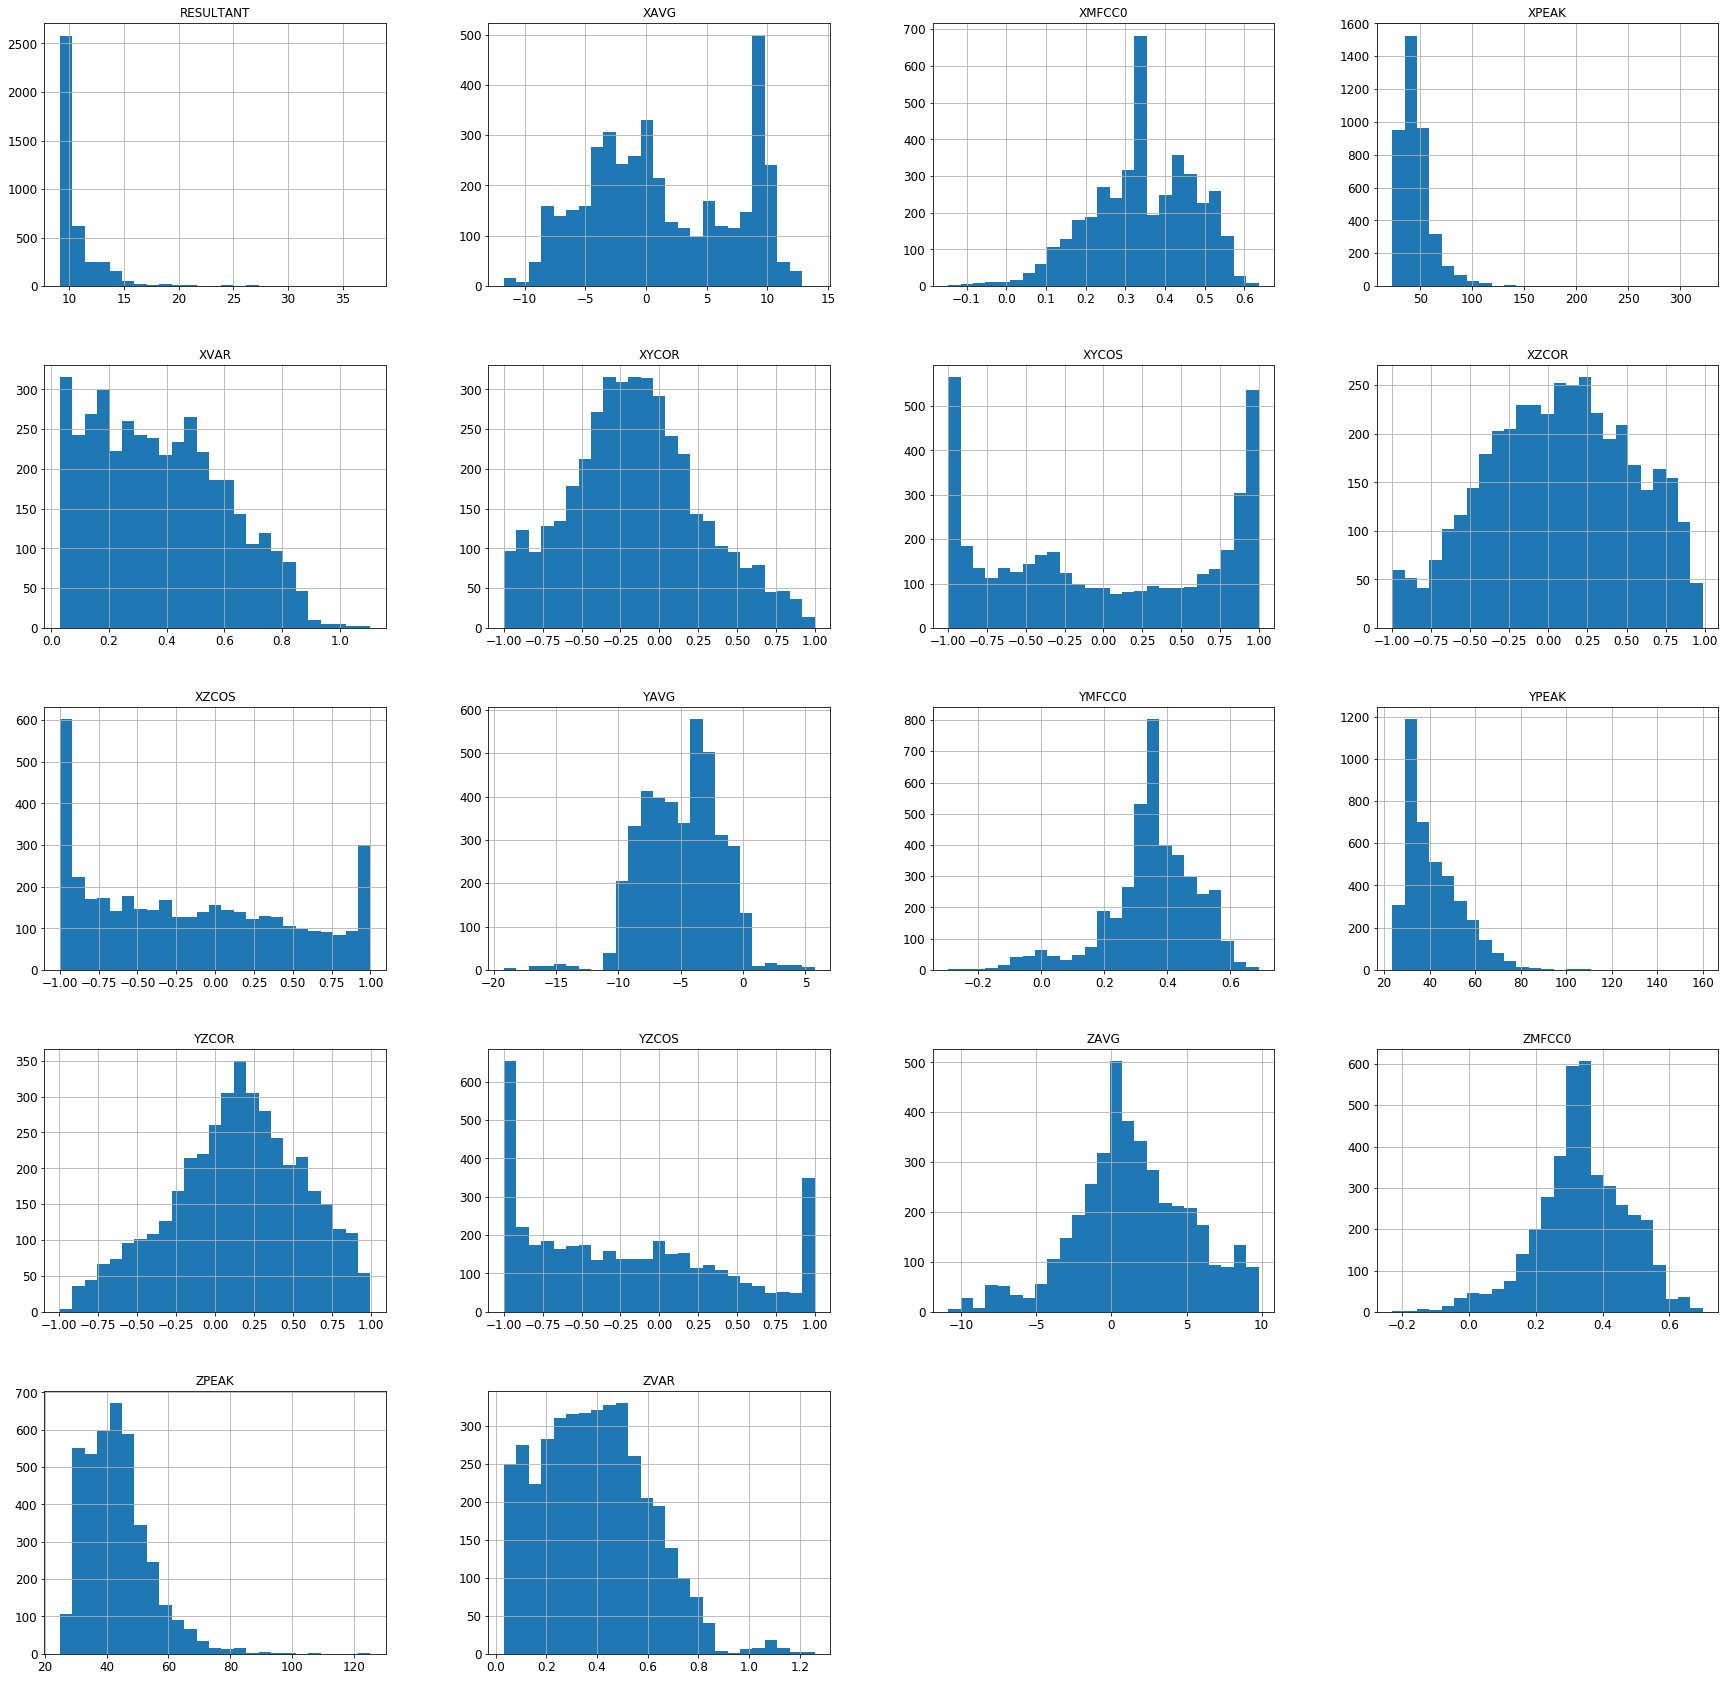

In [78]:
reducedCollection.hist(bins = 25, figsize=(30,30))
plt.show()

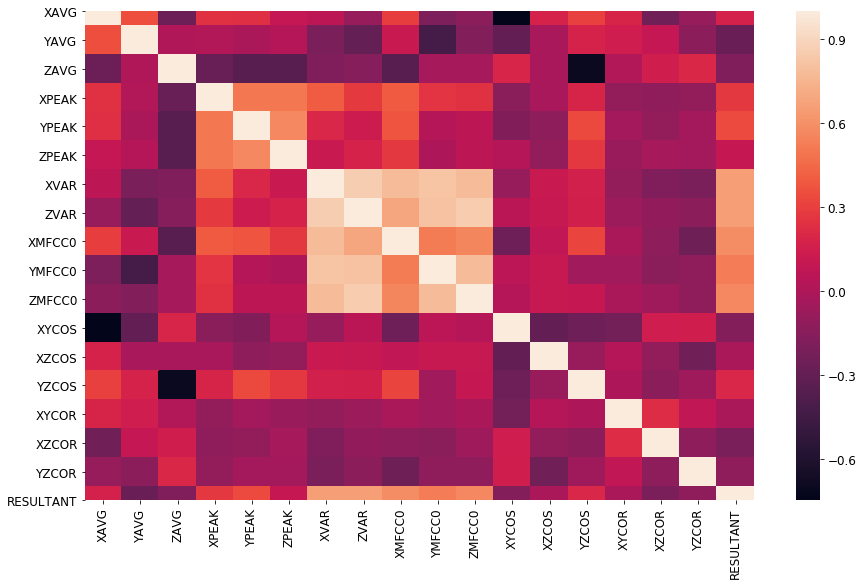

In [80]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(reducedCollection.corr())
plt.show()

Ci-dessus est représenté sous une carte de chaleur la corrélation entre chacun des attributs. 